Space Debris Detection and Response System
Fetching space debris data from NASA API...
Successfully retrieved 217 space objects data!
         des orbit_id                 jd                 cd  \
0  2025 QG16        5  2460921.591352957  2025-Sep-03 02:12   
1   2025 RY6        1  2460921.621027544  2025-Sep-03 02:54   
2   2025 QV5        8  2460921.965348926  2025-Sep-03 11:10   
3   2025 QD8       10  2460922.123788519  2025-Sep-03 14:58   
4    2025 RA        9  2460922.190625384  2025-Sep-03 16:35   

                  dist             dist_min             dist_max  \
0   0.0166089233240976   0.0165549692616432   0.0166628765906671   
1   0.0245157145643138   0.0242934189513811   0.0247380114896888   
2   0.0053809167132423  0.00537792142475276   0.0053839119182805   
3  0.00145942944561569   0.0014589132083073  0.00145994567497571   
4   0.0478619869969167   0.0478380242729152   0.0478859496432766   

              v_rel             v_inf t_sigma_f       h  
0  11.8623566175416 

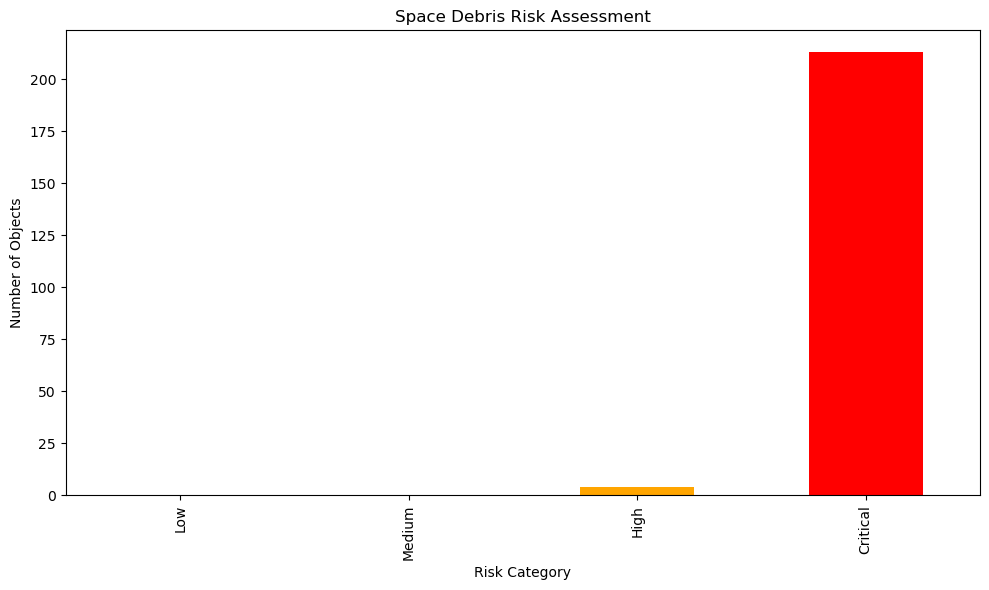

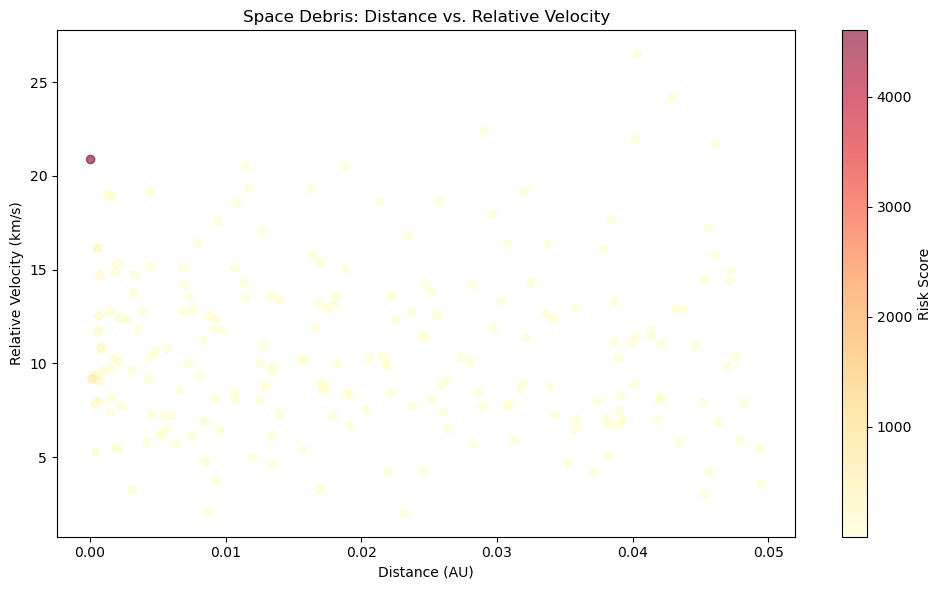


Simulating Debris Response System...
ALERT: 217 high-risk objects detected!

Top 5 highest risk objects:
          des orbit_id                 jd                 cd      dist  \
167   2025 TF        3  2460949.533947033  2025-Oct-01 00:49  0.000045   
123  2025 SU4        5  2460942.857187001  2025-Sep-24 08:34  0.000150   
179   2025 TC        3  2460951.773683586  2025-Oct-03 06:34  0.000573   
86   2025 SY1        1  2460937.933552030  2025-Sep-19 10:24  0.000382   
173   2025 TP        2  2460950.386847146  2025-Oct-01 21:17  0.000719   

     dist_min              dist_max      v_rel      v_inf t_sigma_f       h  \
167  0.000045  4.54119162438118e-05  20.876114  17.839255     00:01  31.702   
123  0.000150  0.000149679587337739   9.180838   6.976248   < 00:01  31.821   
179  0.000572  0.000573169630258572  16.145101  15.854304   < 00:01  27.030   
86   0.000382  0.000382744650869616   7.851781   6.907679   < 00:01  31.665   
173  0.000718  0.000721039066343401  14.710296  14.456

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import time

# NASA Space Apps Challenge 2025: Space Debris Detection and Response System
print("Space Debris Detection and Response System")
print("==========================================")

# NASA's Space Situational Awareness API endpoint
# Note: Replace with the actual API endpoint when available
url = "https://ssd-api.jpl.nasa.gov/cad.api"  # Close Approach Data API as an example

try:
    print("Fetching space debris data from NASA API...")
    
    # Parameters for the API request - looking for close approaches to Earth
    # Adjust these parameters based on your specific needs
    params = {
        'date-min': (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d'),
        'date-max': (datetime.now() + timedelta(days=30)).strftime('%Y-%m-%d'),
        'dist-max': '0.05',  # in AU (astronomical units)
        'body': 'Earth'
    }
    
    # Make the API request
    response = requests.get(url, params=params, timeout=15)
    response.raise_for_status()
    data = response.json()
    
    # Process the data
    if 'data' in data and data['data']:
        # Convert to DataFrame
        columns = data['fields']
        df = pd.DataFrame(data['data'], columns=columns)
        
        print(f"Successfully retrieved {len(df)} space objects data!")
        print(df.head())
        
        # Convert numeric columns
        numeric_cols = ['dist', 'dist_min', 'v_rel', 'v_inf', 'h']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Add a risk assessment column (simplified example)
        if 'dist' in df.columns and 'v_rel' in df.columns:
            # Higher risk for closer objects moving faster
            df['risk_score'] = (1/df['dist']) * df['v_rel'] / 100
            
            # Categorize risk
            df['risk_category'] = pd.cut(
                df['risk_score'], 
                bins=[0, 0.1, 0.5, 1, float('inf')],
                labels=['Low', 'Medium', 'High', 'Critical']
            )
        
        # Visualization 1: Risk Distribution
        if 'risk_category' in df.columns:
            plt.figure(figsize=(10, 6))
            risk_counts = df['risk_category'].value_counts().sort_index()
            risk_counts.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
            plt.title('Space Debris Risk Assessment')
            plt.xlabel('Risk Category')
            plt.ylabel('Number of Objects')
            plt.tight_layout()
            plt.show()
        
        # Visualization 2: Distance vs. Velocity
        if 'dist' in df.columns and 'v_rel' in df.columns:
            plt.figure(figsize=(10, 6))
            plt.scatter(df['dist'], df['v_rel'], alpha=0.6, c=df['risk_score'], cmap='YlOrRd')
            plt.colorbar(label='Risk Score')
            plt.title('Space Debris: Distance vs. Relative Velocity')
            plt.xlabel('Distance (AU)')
            plt.ylabel('Relative Velocity (km/s)')
            plt.tight_layout()
            plt.show()
        
        # Simulation: Debris Response System
        print("\nSimulating Debris Response System...")
        high_risk = df[df['risk_category'].isin(['High', 'Critical'])] if 'risk_category' in df.columns else pd.DataFrame()
        
        if not high_risk.empty:
            print(f"ALERT: {len(high_risk)} high-risk objects detected!")
            print("\nTop 5 highest risk objects:")
            print(high_risk.sort_values('risk_score', ascending=False).head(5))
            
            print("\nRecommended actions:")
            print("1. Notify space agencies and satellite operators")
            print("2. Calculate precise trajectories for collision avoidance")
            print("3. Prepare evasive maneuvers for affected satellites")
            print("4. Monitor objects continuously for trajectory changes")
        else:
            print("No high-risk objects detected in the current timeframe.")
    else:
        print("No close approach data available for the specified parameters.")

except requests.exceptions.RequestException as e:
    print(f"API Request Error: {e}")
    print("\nFalling back to simulation mode...")
    
    # Create a simulated dataset for space debris
    n_objects = 500
    
    # Generate realistic orbital parameters
    orbits = ['LEO', 'MEO', 'GEO', 'HEO']
    orbit_altitudes = {'LEO': (160, 2000), 'MEO': (2000, 35786), 'GEO': (35786, 35786), 'HEO': (1000, 40000)}
    
    # Create simulated data
    np.random.seed(42)
    data = {
        'object_id': [f'DEBRIS-{i:04d}' for i in range(1, n_objects+1)],
        'orbit_type': np.random.choice(orbits, n_objects, p=[0.7, 0.15, 0.1, 0.05]),
        'size_cm': np.random.lognormal(2, 1, n_objects),
        'velocity_km_s': np.random.normal(7.8, 1.2, n_objects),
        'detection_timestamp': [datetime.now() - timedelta(minutes=np.random.randint(1, 60*24)) for _ in range(n_objects)]
    }
    
    df = pd.DataFrame(data)
    
    # Add altitude based on orbit type
    df['altitude_km'] = df.apply(lambda row: np.random.randint(*orbit_altitudes[row['orbit_type']]), axis=1)
    
    # Calculate collision risk (simplified model)
    df['distance_to_satellite_km'] = np.random.exponential(100, n_objects)
    df['time_to_closest_approach_hrs'] = np.random.uniform(0, 48, n_objects)
    df['collision_probability'] = 1 / (df['distance_to_satellite_km'] + 1) * np.exp(-0.1 * df['time_to_closest_approach_hrs'])
    
    # Risk categorization
    df['risk_category'] = pd.cut(
        df['collision_probability'], 
        bins=[0, 0.01, 0.05, 0.2, 1],
        labels=['Low', 'Medium', 'High', 'Critical']
    )
    
    print("Simulated space debris detection system activated")
    print(f"Detected {len(df)} objects in Earth orbit")
    print(df.head())
    
    # Visualization 1: Risk Distribution
    plt.figure(figsize=(10, 6))
    risk_counts = df['risk_category'].value_counts().sort_index()
    risk_counts.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
    plt.title('Space Debris Risk Assessment')
    plt.xlabel('Risk Category')
    plt.ylabel('Number of Objects')
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Orbit Type Distribution with Risk
    plt.figure(figsize=(12, 6))
    orbit_risk = pd.crosstab(df['orbit_type'], df['risk_category'])
    orbit_risk.plot(kind='bar', stacked=True, color=['green', 'yellow', 'orange', 'red'])
    plt.title('Risk Distribution by Orbit Type')
    plt.xlabel('Orbit Type')